In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])

Build a "plain" time-series LSTM (takes a sequence of previous values & predicts the next):

In [3]:
data = data[data["year"] < 2022][["iso3", "year", "net_migration"]]

In [4]:
data = data.pivot(index='year', columns='iso3', values='net_migration')
data

iso3,ABW,AFG,AGO,ALB,AND,ARE,ARG,ARM,ASM,ATG,...,VEN,VGB,VIR,VNM,VUT,WSM,YEM,ZAF,ZMB,ZWE
year,,,,,,,,,,,,,,,,,,,,,
1960,0.537799,0.538444,0.526967,0.541647,0.537958,0.538769,0.542850,0.540890,0.537735,0.537710,...,0.539871,0.537777,0.538057,0.537799,0.537799,0.537681,0.533554,0.542481,0.536835,0.535755
1961,0.537658,0.539312,0.525621,0.541618,0.537961,0.538810,0.545059,0.541180,0.537776,0.537630,...,0.539302,0.537764,0.538211,0.537799,0.537799,0.537633,0.533468,0.551688,0.536720,0.535674
1962,0.537648,0.539536,0.524289,0.541584,0.537964,0.538816,0.545075,0.541489,0.537775,0.537622,...,0.538883,0.537763,0.538249,0.537799,0.537799,0.537572,0.533381,0.554652,0.536622,0.535588
1963,0.537639,0.539453,0.522999,0.541515,0.537965,0.538799,0.545385,0.541807,0.537775,0.537617,...,0.538614,0.537764,0.538255,0.537799,0.537799,0.537552,0.533289,0.555372,0.536554,0.535480
1964,0.537630,0.539552,0.519986,0.541417,0.537966,0.538770,0.545802,0.542114,0.537775,0.537664,...,0.538396,0.537769,0.538257,0.535322,0.537799,0.537556,0.533198,0.556224,0.536508,0.535307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.537853,0.526140,0.557045,0.535381,0.538019,0.534607,0.539019,0.531281,0.537390,0.537799,...,0.335331,0.537869,0.537683,0.536847,0.537699,0.537100,0.527977,0.535155,0.542817,0.522964
2018,0.537890,0.526112,0.553058,0.535545,0.538092,0.535674,0.538960,0.531403,0.537390,0.537799,...,0.201883,0.537854,0.537686,0.537037,0.537699,0.537121,0.527970,0.544550,0.542260,0.522964
2019,0.537901,0.535798,0.552403,0.535598,0.538106,0.536693,0.538908,0.531520,0.537391,0.537799,...,0.296040,0.537862,0.537686,0.536802,0.537699,0.537188,0.527953,0.543426,0.542260,0.522964


Building sequences. Model input will be a sequence of $v$ values, and the target is the next value $v+1$:

In [5]:
def create_sequences(series: list, seq: int) -> tuple:
    sequences = []
    targets = []

    for i in range(len(series) - seq):
        sequence = series[i:i+seq]
        target = series[i+seq]

        sequences.append(sequence)
        targets.append(target)
    
    y_test = targets[-2:]
    X_test = sequences[-2:]
    y_val = targets[-4:-2]
    X_val = sequences[-4:-2]
    y_train = targets[:-4]
    X_train = sequences[:-4]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [6]:
seq = 3

X_train = []
y_train = []
X_val = []
y_val = []
X_test = []
y_test = []

for country in data.columns:
    series = data[country].reset_index(drop=True)
    X_train_i, y_train_i, X_val_i, y_val_i, X_test_i, y_test_i = create_sequences(series=series, seq=seq)
    X_train.extend(X_train_i)
    y_train.extend(y_train_i)
    X_val.extend(X_val_i)
    y_val.extend(y_val_i)
    X_test.extend(X_test_i)
    y_test.extend(y_test_i)

In [7]:
# This part makes me hate Python because above it implicitly creates data structures
# that don't really work here (lists of arrays and of series):

X_train = torch.tensor([x.values for x in X_train], dtype=torch.float32)
y_train = torch.tensor([x.item() for x in y_train], dtype=torch.float32)
X_val = torch.tensor([x.values for x in X_val], dtype=torch.float32)
y_val = torch.tensor([x.item() for x in y_val], dtype=torch.float32)
X_test = torch.tensor([x.values for x in X_test], dtype=torch.float32)
y_test = torch.tensor([x.item() for x in y_test], dtype=torch.float32)

/tmp/ipykernel_11176/614729191.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X_train = torch.tensor([x.values for x in X_train], dtype=torch.float32)


Custom dataset:

In [8]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

In [9]:
train_loader = DataLoader(TimeSeriesDataset(X_train.unsqueeze(-1), y_train), batch_size=32, shuffle=True)
val_loader = DataLoader(TimeSeriesDataset(X_val.unsqueeze(-1), y_val), batch_size=32, shuffle=False)
test_loader = DataLoader(TimeSeriesDataset(X_test.unsqueeze(-1), y_test), batch_size=32, shuffle=False)

Example model architecture:

In [10]:
class LSTMModel(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Pass the last output through the fully connected layer
        out = self.fc(out[:, -1, :])
        return out.squeeze(-1)

Parameters & instantiating model:

In [11]:
input_size = 1  # Since each time step in the sequence has one value
hidden_size = 256
num_layers = 2
output_size = 1  # Predicting a single value

model = LSTMModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
model.to(device)

LSTMModel(
  (lstm): LSTM(1, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

Checkpointing:

In [12]:
def checkpoint(model) -> None:
    torch.save(model.state_dict(), "checkpoint.pth")

def restore_best_weights(model) -> None:
    model.load_state_dict(torch.load("checkpoint.pth"))

Early stopping:

In [13]:
class EarlyStopping:
    
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float("Inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            

stopper = EarlyStopping(patience=5)

Loss and optimizer:

In [14]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training:

In [15]:
num_epochs = 100

losses = []

for epoch in range(num_epochs):

    # Train step:

    model.train()
    epoch_train_loss = 0
    for seq, target in train_loader:
        seq, target = seq.to(device), target.to(device)

        output = model(seq)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
    
    # Validation step:

    with torch.no_grad():
        epoch_val_loss = 0
        for seq, target in val_loader:
            pred = model(seq)  
            loss = criterion(pred, target)
            epoch_val_loss += loss.item()
    
    # Housekeeping:

    stopper(epoch_val_loss)

    print(f"Epoch {epoch+1} done: Training loss: {epoch_train_loss:.4f}, Validation loss: {epoch_val_loss:.4f}, Patience counter: {stopper.counter}")
    losses.append({"epoch": epoch+1, "training": epoch_train_loss, "validation": epoch_val_loss})
        
    if stopper.counter == 0:
        checkpoint(model)
        
    if stopper.early_stop:
        print(f"Patience exceeded, stopping training & restoring best weights...")
        restore_best_weights(model)
        break


Epoch 1 done: Training loss: 2.2156, Validation loss: 0.0184, Patience counter: 0
Epoch 2 done: Training loss: 0.3334, Validation loss: 0.0124, Patience counter: 0
Epoch 3 done: Training loss: 0.2899, Validation loss: 0.0122, Patience counter: 0
Epoch 4 done: Training loss: 0.2681, Validation loss: 0.0094, Patience counter: 0
Epoch 5 done: Training loss: 0.2648, Validation loss: 0.0087, Patience counter: 0
Epoch 6 done: Training loss: 0.2531, Validation loss: 0.0082, Patience counter: 0
Epoch 7 done: Training loss: 0.2559, Validation loss: 0.0081, Patience counter: 0
Epoch 8 done: Training loss: 0.2517, Validation loss: 0.0225, Patience counter: 1
Epoch 9 done: Training loss: 0.2355, Validation loss: 0.0063, Patience counter: 0
Epoch 10 done: Training loss: 0.2179, Validation loss: 0.0058, Patience counter: 0
Epoch 11 done: Training loss: 0.2113, Validation loss: 0.0088, Patience counter: 1
Epoch 12 done: Training loss: 0.2135, Validation loss: 0.0058, Patience counter: 0
Epoch 13 done

/tmp/ipykernel_11176/3484606476.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint.pth"))


## Model Evaluation

<Axes: xlabel='epoch', ylabel='value'>

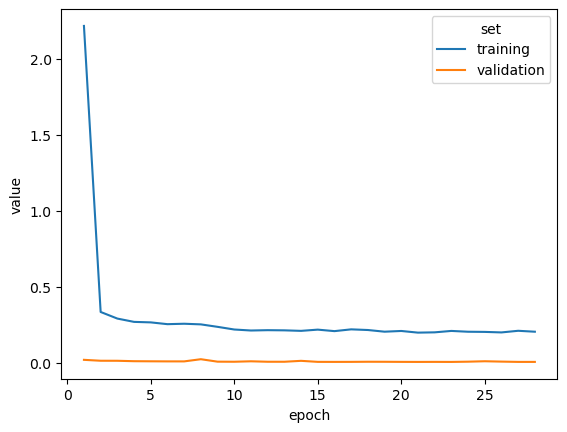

In [16]:
sns.lineplot(
    data=pd.DataFrame(losses).melt(id_vars="epoch", var_name="set"),
    x="epoch",
    y="value",
    hue="set"
)

In [17]:
def eval(model: LSTMModel, test_loader: DataLoader):
    model.eval()
    
    mse = []
    mae = []
    
    with torch.no_grad():
        for seqs, targets in test_loader:
            outputs = model(seqs)
            
            mse_i = F.mse_loss(outputs, targets, reduction='mean').item()
            mse.append(mse_i)

            mae_i = F.l1_loss(outputs, targets, reduction='mean').item()
            mae.append(mae_i)
    
    metrics = {
        "MSE": np.mean(mse),
        "RMSE": np.sqrt(np.mean(mse)),
        "MAE": np.mean(mae)
    }
    
    return metrics

def collect_predictions(model: LSTMModel, data_loader: DataLoader) -> tuple:
    model.eval()
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for features, targets in data_loader:
            outputs = model(features)
            predictions.extend(outputs.cpu().numpy().flatten())
            actuals.extend(targets.cpu().numpy().flatten())
    
    return predictions, actuals

In [18]:
eval(model, test_loader)

{'MSE': 0.0004237504587243685,
 'RMSE': 0.020585199992333533,
 'MAE': 0.007208116319296616}

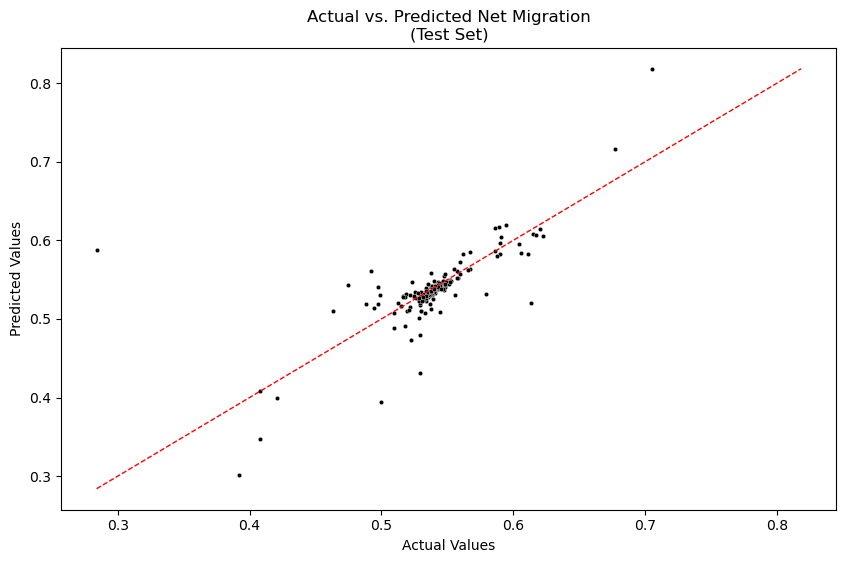

In [19]:
predictions, actuals = collect_predictions(model, test_loader)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=actuals, y=predictions, color="black", s=10)
# Main diagonal:
min_val = min(min(actuals), min(predictions))
max_val = max(max(actuals), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Net Migration\n(Test Set)')
plt.show()